# **Aula 1: Analisando sentimentos**

## **Classificando sentimentos**

Modelo: [DistilBERT base uncased finetuned SST-2](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english)

In [1]:
%pip install -q transformers torch
import os
import torch
from transformers import pipeline

if torch.backends.mps.is_available():
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    os.environ["USE_MPS"] = "1"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["PYTORCH_MPS_DEVICE_OVERRIDE"] = "1"
    device = torch.device('mps')
    torch.set_default_device(device)
    print(f"Using device: {device}")
else:
    device = torch.device('cpu')
    torch.set_default_device(device)
    print(f"Using device: {device}")


Note: you may need to restart the kernel to use updated packages.
Using device: mps


In [2]:
classificador_sentimento = pipeline('sentiment-analysis', 
                                   model='distilbert-base-uncased-finetuned-sst-2-english', 
                                   device=device)

In [3]:
classificador_sentimento('I love this product')

[{'label': 'POSITIVE', 'score': 0.9998788833618164}]

In [4]:
classificador_sentimento('I am totally disappointed with this product')

[{'label': 'NEGATIVE', 'score': 0.9998010993003845}]

## **Selecionando o modelo**

Modelo: [pysentimiento/bertweet-pt-sentiment](https://huggingface.co/pysentimiento/bertweet-pt-sentiment)

In [5]:
from pysentimiento import create_analyzer

In [6]:
def create_model():
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model = create_analyzer(
        task='sentiment',
        lang='pt',
        device=device
    )
    model.model.to(device)
    model.tokenizer.model_max_length = 512
    return model

modelo_analise_sentimento = create_model()

In [7]:
modelo_analise_sentimento = create_analyzer(task='sentiment', 
                                           lang='pt',
                                           device="mps")

In [8]:
modelo_analise_sentimento.predict('''
A fritadeira é sensacional, muito além do que imaginava. É linda, super funcional e muito fácil de manusear.
Fácil de limpar e potente. Super recomendo.
''')

AnalyzerOutput(output=POS, probas={POS: 0.989, NEU: 0.009, NEG: 0.002})

In [9]:
modelo_analise_sentimento.predict('''
Após poucos meses de uso a carcaça de aço escovado começou a oxidar,
demonstrando a baixa qualidade de proteção. Fora esse detalhe, o produto cumpre o prometido.
'''
)

AnalyzerOutput(output=NEU, probas={NEU: 0.921, NEG: 0.065, POS: 0.014})

In [10]:
modelo_analise_sentimento.predict('''
Em menos de 1 ano parou de funcionar, enviei para assistência técnica por estar na garantia,
trocaram o motor, passou a ficar menos potente e não durou 2 utilizações.
Isso se repetiu várias vezes, até que desisti de ficar levando lá e queimando de novo em seguida,
vi outros clientes com o mesmo problema. Não comprem!!
'''
)

AnalyzerOutput(output=NEG, probas={NEG: 0.935, NEU: 0.056, POS: 0.009})

## **Aplicando o modelo aos dados**

In [11]:
import pandas as pd

In [12]:
dados = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/hugging_face/main/Dados/resenhas.csv')

In [13]:
dados

,ID,Resenha
0,24,"A fritadeira é sensacional, muito além do que ..."
1,733,"Após usar o produto, achei-o fácil e muito efi..."
2,865,"Muito funcional, prática e moderna."
3,809,"Boa, mas não das melhores pois a frente de vid..."
4,628,Eu comecei a usar e é bem espaçosa. Gostei poi...
5,657,"Usei ela algumas vezes já, muito silenciosa, l..."
6,182,"Superou minhas expectativas, por enquanto tudo..."
7,815,"Chegou no prazo. Amei, é muito linda. Não vejo..."
8,343,"Estou muito satisfeito com a negociação, receb..."
9,624,Lindaaaa amei super indico


In [14]:
# # Falha retornando erro: RuntimeError: Placeholder storage has not been allocated on MPS device!
# # Parece que o método predict não está funcionando com o MPS quando opera em lotes, mas de forma individual funciona.

# resultados_previsao = modelo_analise_sentimento.predict(dados['Resenha'])
# resultados_previsao

In [15]:
print(f'Device selected: {device}')
# Processa as previsões diretamente
# O device já foi configurado na criação do modelo (create_analyzer)

def process_reviews_safe(reviews):
    results = []
    for text in reviews:
        try:
            result = modelo_analise_sentimento.predict(text)
            results.append(result)
        except Exception as e:
            print(f"Error processing text: {e}")
            continue
    return results

# Process reviews one by one
resultados_previsao = process_reviews_safe(dados['Resenha'])
resultados_previsao

Device selected: mps


[AnalyzerOutput(output=POS, probas={POS: 0.989, NEU: 0.009, NEG: 0.002}),
 AnalyzerOutput(output=POS, probas={POS: 0.670, NEU: 0.320, NEG: 0.011}),
 AnalyzerOutput(output=POS, probas={POS: 0.900, NEU: 0.097, NEG: 0.003}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.731, NEU: 0.259, POS: 0.010}),
 AnalyzerOutput(output=POS, probas={POS: 0.976, NEU: 0.021, NEG: 0.003}),
 AnalyzerOutput(output=POS, probas={POS: 0.956, NEU: 0.037, NEG: 0.007}),
 AnalyzerOutput(output=POS, probas={POS: 0.838, NEU: 0.093, NEG: 0.069}),
 AnalyzerOutput(output=POS, probas={POS: 0.990, NEU: 0.008, NEG: 0.002}),
 AnalyzerOutput(output=POS, probas={POS: 0.961, NEU: 0.036, NEG: 0.003}),
 AnalyzerOutput(output=POS, probas={POS: 0.990, NEU: 0.007, NEG: 0.003}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.896, NEU: 0.100, POS: 0.004}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.990, NEU: 0.008, POS: 0.003}),
 AnalyzerOutput(output=NEG, probas={NEG: 0.985, NEU: 0.011, POS: 0.003}),
 AnalyzerOutput(output=NEU, probas={NE

In [16]:
sentimento = []

for resultado in resultados_previsao:
  sentimento.append(resultado.output)

In [17]:
sentimento

['POS',
 'POS',
 'POS',
 'NEG',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'POS',
 'POS',
 'NEU',
 'POS',
 'POS']

In [18]:
dados['Sentimento'] = sentimento

In [19]:
pd.set_option('display.max_colwidth', None) # Mostra as colunas completamente
styled_dados = dados.style.set_properties(**{'text-align': 'left'}) # Alinha o texto à esquerda

# Exibe o dataframe
display(styled_dados)

,ID,Resenha,Sentimento
0,24,"A fritadeira é sensacional, muito além do que imaginava. É linda, super funcional e muito fácil de manusear. Fácil de limpar e potente. Super recomendo.",POS
1,733,"Após usar o produto, achei-o fácil e muito eficiente. Fácil de usar e de limpar.",POS
2,865,"Muito funcional, prática e moderna.",POS
3,809,"Boa, mas não das melhores pois a frente de vidro dificulta na limpeza.",NEG
4,628,Eu comecei a usar e é bem espaçosa. Gostei pois dá para fazer várias coisas ao mesmo tempo.,POS
5,657,"Usei ela algumas vezes já, muito silenciosa, linda demais a cor e o espaço então nem se fala.",POS
6,182,"Superou minhas expectativas, por enquanto tudo certo, porém fiquei decepcionada com as datas de entregas que não estavam certas. Mas do resto tá tudo certo, chegou certinho e sem defeito.",POS
7,815,"Chegou no prazo. Amei, é muito linda. Não vejo a hora de usar.",POS
8,343,"Estou muito satisfeito com a negociação, recebimento tudo ok, e antes do esperado.",POS
9,624,Lindaaaa amei super indico,POS


In [20]:
import plotly.express as px

df_sentimento = dados.groupby('Sentimento').size().reset_index(name='Contagem')

fig = px.bar(df_sentimento, x='Sentimento', y='Contagem', color='Sentimento', title='Contagem de Resenhas por Sentimentos')

fig.show()

In [21]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
portuguese_stopwords = stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/esteban.viveros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
portuguese_stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def nuvem_palavras(texto, coluna_texto, sentimento):
    # Filtrando as resenhas com base no sentimento especificado
    texto_sentimento = texto.query(f'Sentimento == "{sentimento}"')[coluna_texto]

    # Unindo todas as resenhas em uma única string
    texto_unido = ' '.join(texto_sentimento)

    # Dividindo o texto em palavras e filtrando com as stopwords
    palavras = texto_unido.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra not in portuguese_stopwords]
    texto_filtrado = ' '.join(palavras_filtradas)

    # Criando a nuvem de palavras
    nuvem_palavras = WordCloud(width=800, height=500, max_words=50).generate(texto_filtrado)
    plt.figure(figsize=(10, 7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

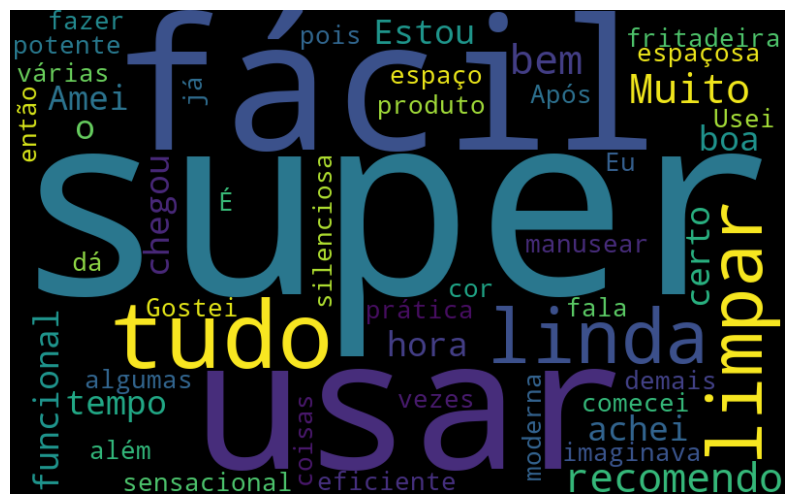

In [24]:
nuvem_palavras(dados, 'Resenha', 'POS')

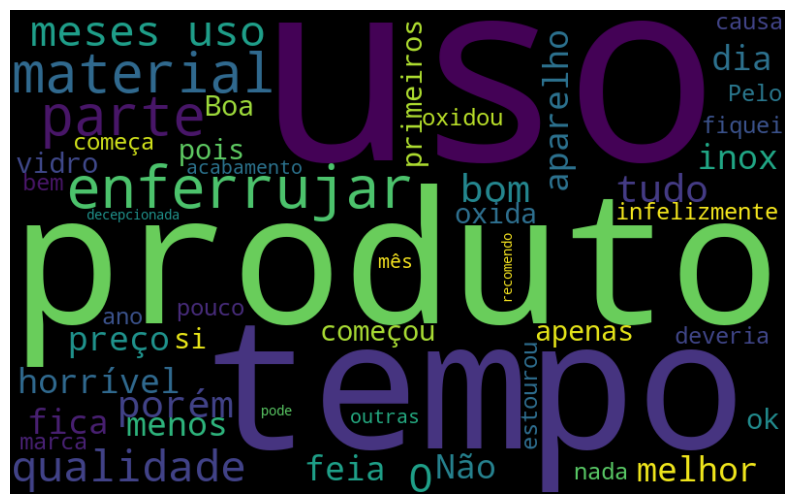

In [25]:
nuvem_palavras(dados, 'Resenha', 'NEG')